Layer .features.Conv2d10 Sampled 128 units from feature tensor of shape (256, 13, 13)
Layer .features.Conv2d8 Sampled 128 units from feature tensor of shape (256, 13, 13)
Layer .features.Conv2d6 Sampled 128 units from feature tensor of shape (384, 13, 13)
Layer .features.Conv2d3 Sampled 128 units from feature tensor of shape (192, 27, 27)
0.030338058
act mat shape:  (1, 512)
act mat shape:  (1, 512)


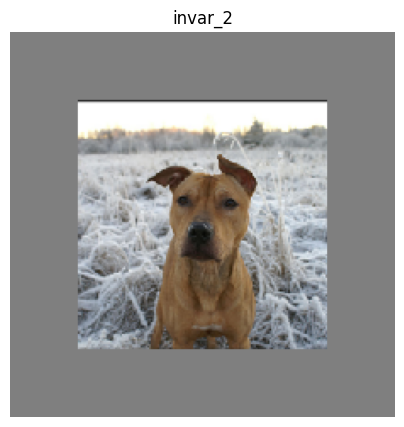

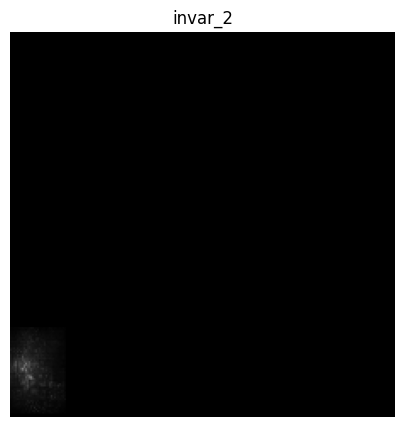

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
:-------------------->  invar_2.JPEG-128-Correlation-conv1-fc6 evol finished! best score: 0.850
plot not saved


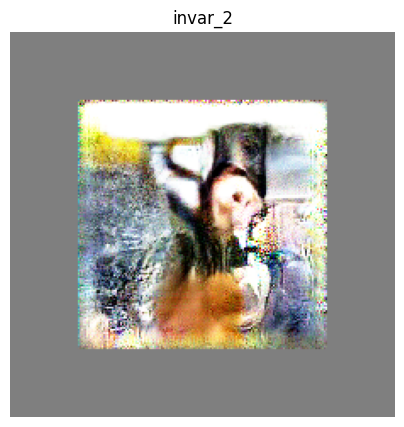

Cleanuping...
Cleanup hooks done.
Cleanup done.


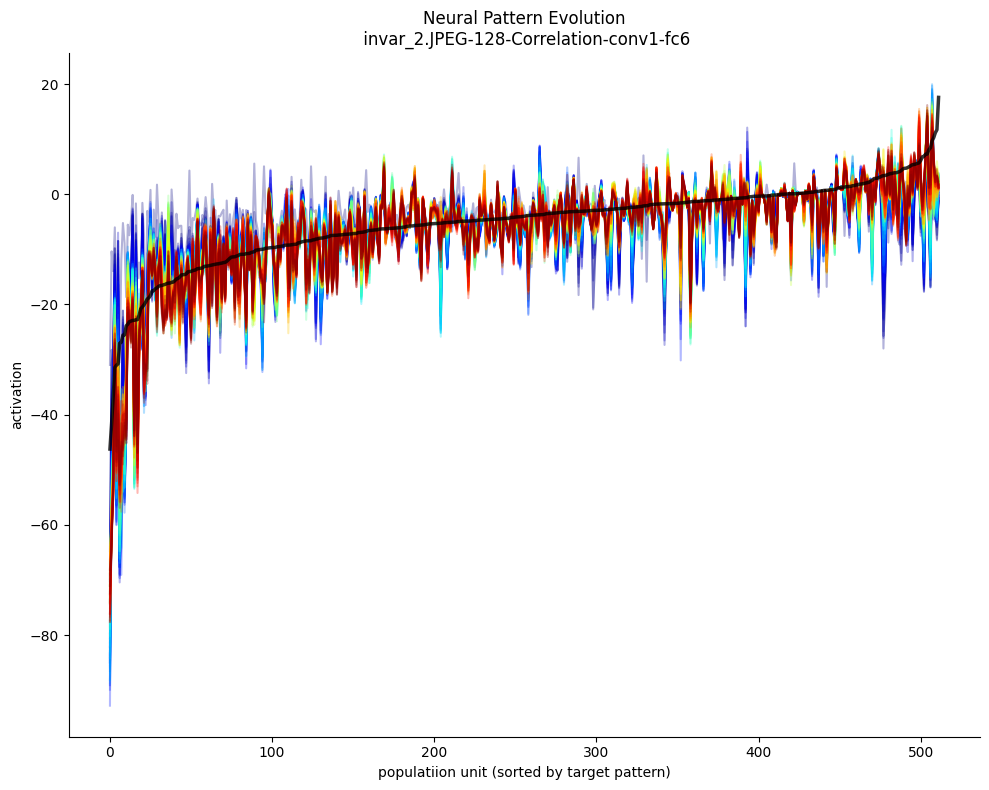

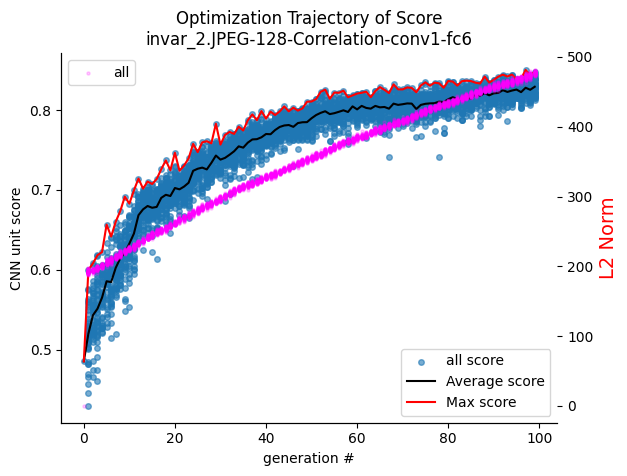

In [21]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\single_image"

net_name = "alexnet"
layer_name = ['.features.Conv2d10', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "conv1"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = 128
score_method = "Correlation"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 2
targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
                scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id, single_col=False, area=False)
#unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
#                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False, singlecol=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()


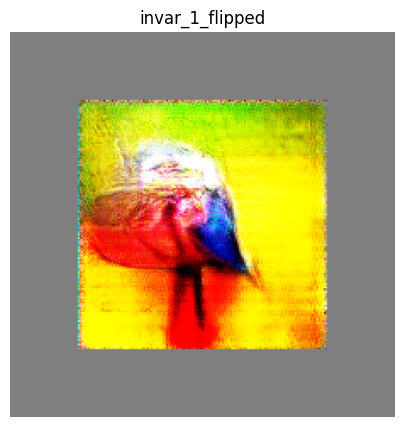

In [4]:

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

Layer .features.Conv2d10 Sampled 128 units from feature tensor of shape (256, 13, 13)
Gaussian Fitting center (158.5, 78.8)
 Cov mat XX 750.1 YY 815.4 XY 0.3
act mat shape:  (1, 128)
act mat shape:  (1, 128)


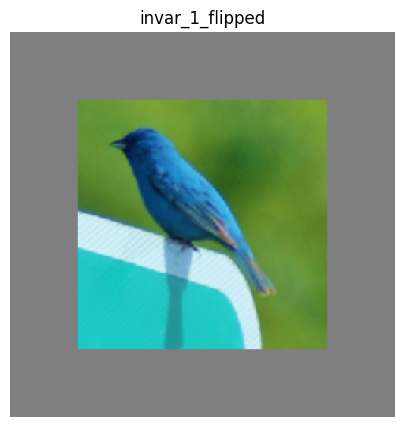

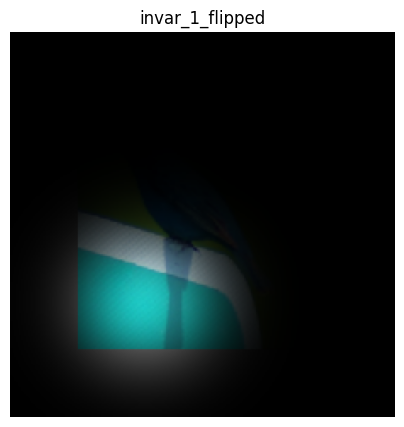

Space dimension: 256, Population size: 28, Select size:14, Optimization Parameters:
Initial sigma: 0.250
cc=0.015, cs=0.151, c1=0.000 damps=1.151
:-------------------->  invar_1_flipped.JPEG-128-cosine-conv1-BigGAN evol finished! best score: 0.885
plot not saved


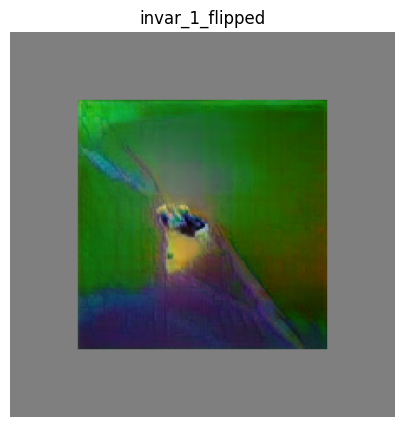

Cleanuping...
Cleanup hooks done.
Cleanup done.


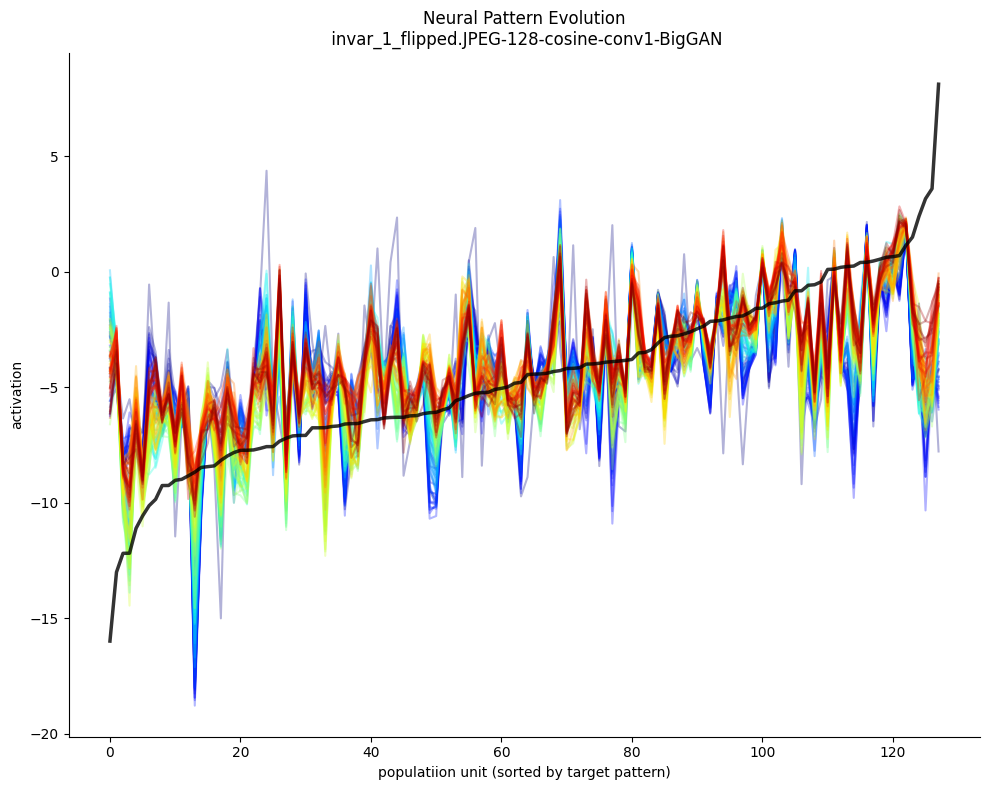

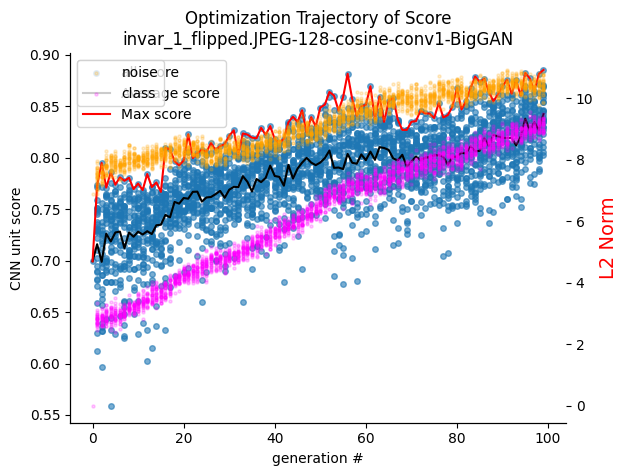

In [18]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN, loadBigGAN, BigGAN_wrapper, load_Hessian
from core.utils.Optimizers import *
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
from pytorch_pretrained_biggan import truncated_noise_sample
#%%
# 

refimgdir = r"C:\Data\cosine\insilico_experiments\data\single_image"
Hdir_BigGAN = r"N:\PonceLab\Data-Computational\Hessian_summary\BigGAN\H_avg_1000cls.npz"
Hdir_fc6 = r"N:\PonceLab\Data-Computational\Hessian_summary\fc6GAN\Evolution_Avg_Hess.npz"

net_name = "alexnet"
layer_name = ['.features.Conv2d10']
#layer_name = ['.features.Conv2d10', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']
layer_short = "conv1"
gan_name = "BigGAN"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = 128
score_method = "cosine"

Hdata = load_Hessian(gan_name, Hdir_BigGAN)
eva = Hdata['eigvals_avg'][::-1]
evc = Hdata['eigvects_avg'][:, ::-1]

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 1

targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]

BGAN = loadBigGAN()
G = BigGAN_wrapper(BGAN)
code_length = 256
fixnoise = 0.7 * truncated_noise_sample(1, 128, seed=0)
init_code = np.concatenate((fixnoise, np.zeros((1, 128))), axis=1)

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 1
unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
                scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id, single_col=False, area=False)
#unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
#                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)

#print("unit mask dict", unit_tsridx_dict_random)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random,
                               layer_name, input_size,show_fig=False, gan_name=gan_name)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)

target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
## set optimizer vanila CMAES
optimizer = CholeskyCMAES(code_length, init_sigma=.25,
                init_code=init_code, Aupdate_freq=102)
## set optimizer with Hessian
#optimizer = HessCMAES(code_length, init_code=init_code, init_sigma=0.3)
#optimizer.set_Hessian(eigvals=eva, eigvects=evc, expon=1 / 2.5)

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None,
        init_code = init_code)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()